## 1: Utilizando a base de dados [Higher Education Students Performance Evaluation](https://www.kaggle.com/datasets/csafrit2/higher-education-students-performance-evaluation), elabore uma solução para identificar a saída GRADE do estudante.

### a) Faça o pré-processamento dos dados (limpeza, engenharia de variáveis, etc). Utilize pelo menos uma forma de redimensionamento de atributos (selecionando ou agregando) e utilize ambas as amostras para avaliar os resultados.

In [1]:
from pandas import read_csv

df = read_csv("databases/student_prediction.csv")

classes = ["Fail", "DD", "DC", "CC", "CB", "BB", "BA", "AA"]

Retiramos colunas que não agregam à analise:

In [2]:
# Removendo colunas de identificação
df = df.drop(columns=["STUDENTID", "COURSE ID"])

Como todos os dados categóricos já foram convertidos em números, não precisamos fazer essa etapa:

In [3]:
df.dtypes

AGE              int64
GENDER           int64
HS_TYPE          int64
SCHOLARSHIP      int64
WORK             int64
ACTIVITY         int64
PARTNER          int64
SALARY           int64
TRANSPORT        int64
LIVING           int64
MOTHER_EDU       int64
FATHER_EDU       int64
#_SIBLINGS       int64
KIDS             int64
MOTHER_JOB       int64
FATHER_JOB       int64
STUDY_HRS        int64
READ_FREQ        int64
READ_FREQ_SCI    int64
ATTEND_DEPT      int64
IMPACT           int64
ATTEND           int64
PREP_STUDY       int64
PREP_EXAM        int64
NOTES            int64
LISTENS          int64
LIKES_DISCUSS    int64
CLASSROOM        int64
CUML_GPA         int64
EXP_GPA          int64
GRADE            int64
dtype: object

Tratamos possíveis dados defeituosos:

In [4]:
# Removendo dados duplicados
df = df.drop_duplicates()
# Removendo dados nulos
df = df.dropna()

Usamos correlação para identificar variáveis independentes que podem ser removidas:

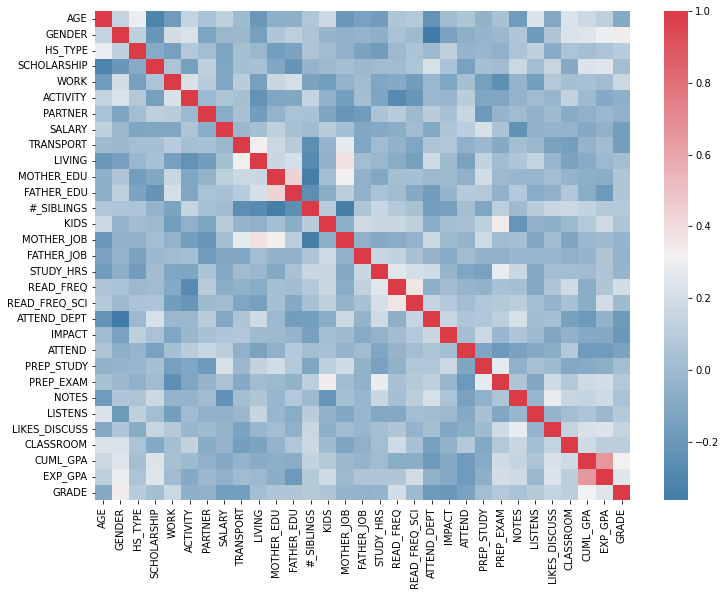

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils.cmap import lukewarm_cmap

plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(), cmap=lukewarm_cmap)
plt.show()

Considerando um nível alto de correlação como >= 0.6, podemos remover o atributo "EXP_GPA" (que nada mais é do que uma previsão do CUML_GPA) em favor de "CUML_GPA".

In [6]:
df_best = df.drop(columns=["EXP_GPA"])

Poderíamos reduzir ainda mais as variáveis juntando as 4 de pai e mãe (escolaridade e trabalho) em uma única de parentes, assim como as 2 sobre leitura de livros. Porém, na minha opinião, isso poderia acarretar numa possível perda de *insight*.

### b) Faça uma análise exploratória dos dados de saída, utilizando box plot, e aplique undersampling ou oversampling para balancear os dados caso preciso.

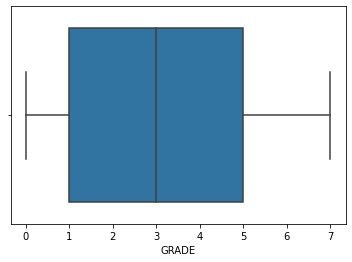

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x="GRADE", data=df)
plt.show()

Podemos notar uma diferença no tamanho das caudas, sem presença de outliers, e que a mediana não está no centro do gráfico. Isso nos mostra um forte desbalanceamento para os valores menores, portanto aplicaremos oversampling através da técnica "Synthetic Minority Over-sampling Technique" implementada pela biblioteca Imbalanced-learn:

In [8]:
from imblearn.over_sampling import SMOTE

df = [df.iloc[:, :-1], df.iloc[:, -1]]
df_best = [df_best.iloc[:, :-1], df_best.iloc[:, -1]]

smote = SMOTE(random_state=2456)
df = smote.fit_resample(df[0], df[1])
df_best = smote.fit_resample(df_best[0], df_best[1])

Com isto, a mediana encontra-se devidamente no centro dos valores e as distâncias entre os percentils e as caudas estãos iguais, portanto as amostras foram balançeadas.

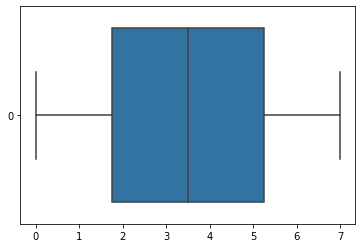

In [9]:
sns.boxplot(data=df_best[1], orient="horizontal")
plt.show()

### c) Utilize a biblioteca AutoML para fazer a previsão, com validação cruzada estratificada 10-fold e "random_state" fixo. Identifique o algoritmo que teve o melhor resultado e avalie-o com 2 métricas de sua preferência e matriz de confusão.

In [ ]:
from autosklearn.classification import AutoSklearnClassifier
from IPython.display import display
from pandas import DataFrame
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from warnings import simplefilter

simplefilter("ignore")

x_train, x_test, y_train, y_test = train_test_split(df[0], df[1], test_size=0.33, random_state=42, stratify=df[1])

automl = AutoSklearnClassifier(
    time_left_for_this_task=60 * 5,
    per_run_time_limit=15,
    resampling_strategy="cv",
    resampling_strategy_arguments={"folds": 10}
)

automl.fit(x_train, y_train)
automl.refit(x_train, y_train)

Para analisar os resultados usaremos a acurácia, visto que as classes estão balanceadas, precisão e sensibilidade (Medida F1). Nota-se que não usaremos a média "micro" pois seus resultados são os mesmos da acurácia em amostras balanceadas.

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
results = automl.predict(x_test)

print(f"Acurácia: {accuracy_score(y_test, results)}")
print(f"Precisão: {precision_score(y_test, results, average='macro')}")
print(f"Sensibilidade: {recall_score(y_test, results, average='macro')}")
print(automl.leaderboard())

Acurácia: 0.7634408602150538
Precisão: 0.7793374925727867
Sensibilidade: 0.7613636363636364
          rank  ensemble_weight                type      cost   duration
model_id                                                                
20           1             0.18          libsvm_svc  0.342246   5.900527
13           2             0.06  passive_aggressive  0.379679  14.718070
19           3             0.12          libsvm_svc  0.406417   6.462634
5            4             0.04          libsvm_svc  0.422460   5.158700
7            5             0.22          libsvm_svc  0.427807   5.512976
15           6             0.20                 lda  0.443850   7.005964
18           7             0.10          libsvm_svc  0.459893   5.696862
4            8             0.08       random_forest  0.695187  12.409815


O melhor algoritmo encontrado foi o SVC (C-Support Vector Classification). Sua performance foi satisfatória, visto que conseguiu uma acurácia de mais de 75%, ainda que esse resultado não seja perfeito ou excelente. Com uma leve diferença entre a precisão e a sensibilidade, o modelo se enganou menos do que falhou em prever corretamente as classes.

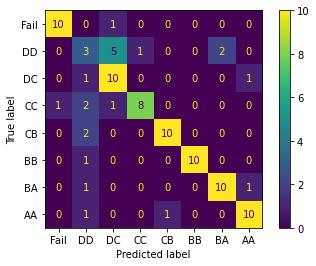

In [22]:
cm = confusion_matrix(y_test, results)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot()
plt.show()

A matriz de confusão nos dá uma visão mais clara do que aconteceu. Na maioria das classes, a taxa de acerto foi fenomenal, entre 80% e 90%. Ele teve um pouco mais de dificuldade na classe "CC", na qual essa taxa caiu para menos de 70%, e foi ainda pior na classe "DD", prevendo menos de 30%.

Abaixo temos um relatório mais detalhado sobre os algoritmos que foram testados:

In [37]:
report = DataFrame(automl.cv_results_).sort_values(by=["rank_test_scores"])

display(report)

,mean_test_score,mean_fit_time,params,rank_test_scores,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,...,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_min,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
18,0.657754,5.900527,"{'balancing:strategy': 'weighting', 'classifie...",1,Success,0.0,weighting,libsvm_svc,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0.620321,14.718070,"{'balancing:strategy': 'none', 'classifier:__c...",2,Success,0.0,none,passive_aggressive,feature_type,polynomial,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,0.593583,6.462634,"{'balancing:strategy': 'weighting', 'classifie...",3,Success,0.0,weighting,libsvm_svc,feature_type,select_rates_classification,...,0.759067,0.238219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fdr
3,0.577540,5.158700,"{'balancing:strategy': 'none', 'classifier:__c...",4,Success,0.0,none,libsvm_svc,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.572193,5.512976,"{'balancing:strategy': 'weighting', 'classifie...",5,Success,0.0,weighting,libsvm_svc,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,0.556150,7.005964,"{'balancing:strategy': 'weighting', 'classifie...",6,Success,0.0,weighting,lda,feature_type,polynomial,...,0.777883,0.185241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.545455,12.181268,"{'balancing:strategy': 'weighting', 'classifie...",7,Success,0.0,weighting,mlp,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,0.545455,4.223334,"{'balancing:strategy': 'none', 'classifier:__c...",7,Success,0.0,none,libsvm_svc,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,0.540107,5.696862,"{'balancing:strategy': 'none', 'classifier:__c...",9,Success,0.0,none,libsvm_svc,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.465241,7.723472,"{'balancing:strategy': 'none', 'classifier:__c...",10,Success,0.0,none,mlp,feature_type,liblinear_svc_preprocessor,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### d) Teste e avalie 3 variações dos hiperparâmetros do método encontrado anteriormente.

Por motivos de simplicidade, dado que a biblioteca Auto-sklearn NÃO nos fornece uma maneira fácil de rodar métodos separados ou sequer de recuperar os parâmetros usados, faremos uma cópia manual dos parâmetros para as questões posteriores.

In [188]:
# Identificando hiperparâmetros do melhor algoritmo
bestParams = report.loc[report.rank_test_scores == 1, "params"].squeeze()

print(f"Parâmetros:\n{bestParams}")

origParams = {
    "C": 21.59109048521139,
    "gamma": 5.060493057005212,
    "kernel": "rbf",
    "max_iter": -1,
    "shrinking": False,
    "tol": 0.00012027336497045934
}

Parâmetros:
{'balancing:strategy': 'weighting', 'classifier:__choice__': 'libsvm_svc', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:libsvm_svc:C': 21.59109048521139, 'classifier:libsvm_svc:gamma': 5.060493057005212, 'classifier:libsvm_svc:kernel': 'rbf', 'classifier:libsvm_svc:max_iter': -1, 'classifier:libsvm_svc:shrinking': 'False', 'classifier:libsvm_svc:tol': 0.00012027336497045934, 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'normalize', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.017236598742666608

Para os testes, mudaremos o tipo de kernel utilizado.

In [210]:
from sklearn.svm import SVC

params = [origParams.copy(), origParams.copy(), origParams.copy()]

params[0].update({"kernel": "linear"})
params[1].update({"kernel": "poly"})
params[2].update({"kernel": "precomputed"})

In [211]:
svc = SVC(**params[0])
svc.fit(x_train, y_train)
results = svc.predict(x_test)

print(f"Acurácia: {accuracy_score(y_test, results)}")
print(f"Precisão: {precision_score(y_test, results, average='macro')}")
print(f"Sensibilidade: {recall_score(y_test, results, average='macro')}")

Acurácia: 0.5591397849462365
Precisão: 0.5766042780748664
Sensibilidade: 0.5549242424242424


In [200]:
svc = SVC(**params[1])
svc.fit(x_train, y_train)
results = svc.predict(x_test)

print(f"Acurácia: {accuracy_score(y_test, results)}")
print(f"Precisão: {precision_score(y_test, results, average='macro')}")
print(f"Sensibilidade: {recall_score(y_test, results, average='macro')}")

Acurácia: 0.6344086021505376
Precisão: 0.6729471916971916
Sensibilidade: 0.6306818181818181


In [206]:
from sklearn.svm import SVC

svc = SVC(**params[2])
svc.fit(x_train, y_train)
results = svc.predict(x_test)

print(f"Acurácia: {accuracy_score(y_test, results)}")
print(f"Precisão: {precision_score(y_test, results, average='macro')}")
print(f"Sensibilidade: {recall_score(y_test, results, average='macro')}")

ValueError: Precomputed matrix must be a square matrix. Input is a 187x30 matrix.

## 2: Utilizando a mesma base de dados da questão anterior:

### a) Agrupe os resultados através do método k-means, com k = 5 e k = 7.

### b) Agrupe os resultados através do método hierárquico, para 5 e 7 grupos e com 2 tipos diferentes de linkage.

### c) Compare os resultados das execuções anteriores e avalie uma métrica de avaliação para clusterização.

## 3: Quais são as vantagens e desvantagens de utilizar a biblioteca AutoML? Como você faria para usá-la, garantindo os melhores resultados possíveis?